# Augment Keypoints/Landmarks

Keypoints in `imgaug` are points on images, given as absolute x- and y- pixel coordinates with subpixel accuracy (i.e. as floats with value range `[0, S)`, where `S` denotes the size of an axis). In the literature they are also called "landmarks" and may be used for e.g. human pose estimation.

In `imgaug`, keypoints are only affected by augmenters changing the geometry of images. This is the case for e.g. horizontal flips or affine transformations. They are not affected by other methods, such as gaussian noise.

Two classes are provided for keypoint augmentation in `imgaug`, listed in the following sections.

## API: Keypoint

`imgaug.augmentables.kps.Keypoint`: A very simple class instantiated as `Keypoint(x=<number>, y=<number>)`. Noteworthy methods of the class are:
  * `project(from_shape, to_shape)`: Used to project keypoints from one image shape to another one, e.g. after image resizing.
  * `shift(x=0, y=0)`: Used to move points on the x/y-axis. Returns a new Keypoint.
  * `draw_on_image(image, color=(0, 255, 0), alpha=1.0, size=3, copy=True, raise_if_out_of_image=False)`: Draw this keypoint on an image.

## API: KeypointsOnImage

`imgaug.augmentables.kps.KeypointsOnImage`: Combines a list of keypoints with an image shape. It is instantiated as 
`KeypointsOnImage(keypoints, shape)`, where `keypoints` is a list of `Keypoint` instances and `shape` is the shape of the image on which the keypoints are placed. Both arguments are later available as `.keypoints` and `.shape` attributes. Noteworthy methods are:
  * `on(image)`: Used to project the keypoints onto a new image, e.g. after image resizing.
  * `draw_on_image(image, color=(0, 255, 0), alpha=1.0, size=3, copy=True, raise_if_out_of_image=False)`: Draw keypoints as squares onto an image. The image must be given as a numpy array.
  * `shift(x=0, y=0)`: Analogous to the method in `Keypoint`, but shifts all Keypoints in `.keypoints`.
  * `to_xy_array()`: Transforms the instance to a `(N, 2)` numpy array.
  * `from_xy_array(xy, shape)`: Creates an instance of `KeypointsOnImage` from an `(N, 2)` array. `shape` is the shape of the corresponding image.
  * `to_distance_maps(inverted=False)`: Converts the keypoints to (euclidean) distance maps in the size of the image. Result is of shape `(H, W, N)`, with `N` being the number of keypoints.
  * `from_distance_maps(distance_maps, inverted=False, if_not_found_coords={"x": -1, "y": -1}, threshold=None, nb_channels=None)`: Inverse function for `to_distance_maps()`.

## API: Methods

To augment keypoints, the method `augment(images=..., keypoints=...)` may be called. An alternative is `augment_keypoints()`, which only handles keypoint data and expects a single instance of `KeypointsOnImage` or a list of that class.

## API: More

For more details, see the [API](https://imgaug.readthedocs.io/en/latest/source/api.html): [Keypoint](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.kps.Keypoint), [KeypointsOnImage](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.kps.KeypointsOnImage), [imgaug.augmenters.meta.Augmenter.augment()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment), [imgaug.augmenters.meta.Augmenter.augment_keypoints()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment_keypoints).

## Basic example

Let's take a look at a simple example, in which we augment an image and five keypoints on it by applying an affine transformation. As the first step, we load an example image from the web:

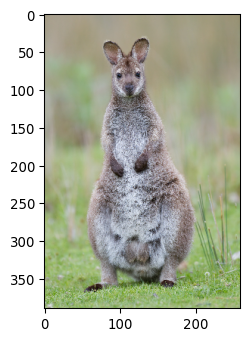

In [1]:
import imageio
import imgaug as ia
%matplotlib inline

image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/e/e6/Macropus_rufogriseus_rufogriseus_Bruny.jpg")
image = ia.imresize_single_image(image, (389, 259))
ia.imshow(image)

Now let's place and visualize a few keypoints:

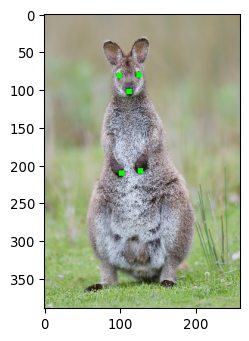

In [3]:
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage
kps = [
    Keypoint(x=99, y=81),   # left eye (from camera perspective)
    Keypoint(x=125, y=80),  # right eye
    Keypoint(x=112, y=102), # nose
    Keypoint(x=102, y=210), # left paw
    Keypoint(x=127, y=207)  # right paw
]
kpsoi = KeypointsOnImage(kps, shape=image.shape)

ia.imshow(kpsoi.draw_on_image(image, size=7))

Note how we "merged" all keypoints of the image in an instance of `KeypointsOnImage`. We will soon augment that instance. In case you have to process the keypoints after augmentation, they can be accesses via the `.keypoints` attribute:

In [4]:
print(kpsoi.keypoints)

[Keypoint(x=99.00000000, y=81.00000000), Keypoint(x=125.00000000, y=80.00000000), Keypoint(x=112.00000000, y=102.00000000), Keypoint(x=102.00000000, y=210.00000000), Keypoint(x=127.00000000, y=207.00000000)]


Now to the actual augmentation. We want to apply an affine transformation, which will alter both the image and the keypoints. We choose a bit of translation and rotation as our transformation. Additionally, we add a bit of color jittering to the mix. That color jitter is only going to affect the image, not the keypoints.

In [5]:
import imgaug.augmenters as iaa
ia.seed(3)

seq = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 30)}, rotate=(-10, 10)),
    iaa.AddToHueAndSaturation((-50, 50))  # color jitter, only affects the image
])

And now we apply our augmentation sequence to both the image and the keypoints. We can do this by calling `seq.augment(...)` or its shortcut `seq(...)`:

In [6]:
image_aug, kpsoi_aug = seq(image=image, keypoints=kpsoi)

In [8]:
type(kpsoi)

imgaug.augmentables.kps.KeypointsOnImage

If you have more than one image, you have to use `images=...` instead of `image=...`. You will also have to provide a list as input to `keypoints`. Though that list does not necessarily have to contain `KeypointsOnImage` instances. You may also provide (per image) a list of `Keypoint` instances or a list of `(x,y)` tuples or an `(N,2)` numpy array.

Make sure however to provide both images and keypoints in a single call to `augment()`. Calling it two times -- once with the images as argument and once with the keypoints -- will lead to different sampled random values for the two datatypes.

Now let's visualize the image and keypoints before/after augmentation:

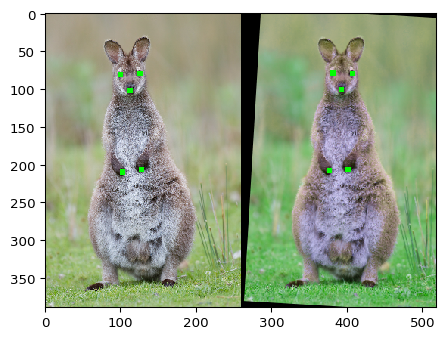

In [6]:
import numpy as np
ia.imshow(
    np.hstack([
        kpsoi.draw_on_image(image, size=7),
        kpsoi_aug.draw_on_image(image_aug, size=7)
    ])
)

## Projecting Keypoints onto other Images

When working with keypoints, you might at some point have to change the image size. The method `KeypointsOnImage.on(image or shape)` can be used to recompute keypoint coordinates after changing the image size. It projects the keypoints onto the same *relative* positions on a new image. In the following code block, the initial example image is increased to twice the original size. Then (1st) the keypoints are drawn and visualized on the original image, (2nd) drawn and visualized on the resized image without using `on()` and (3rd) drawn and visualized in combination with `on()`.

Small image (389, 259, 3) with keypoints optimized for the size:


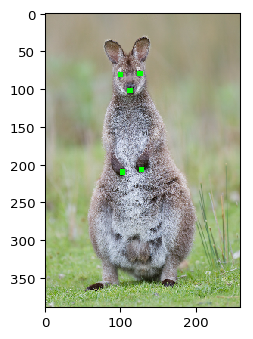

Large image (778, 518, 3) with keypoints optimized for the small image size:


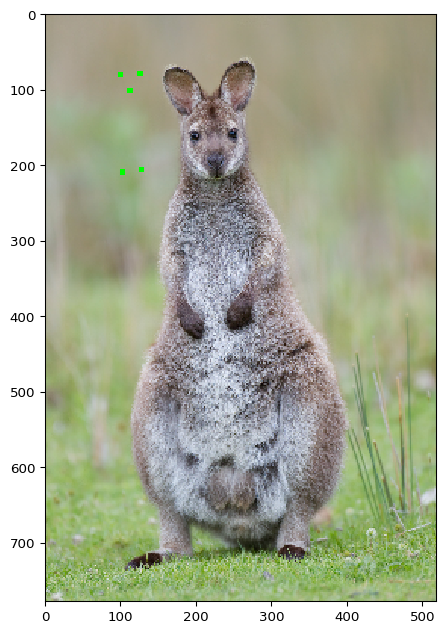

Large image (778, 518, 3) with keypoints projected onto that size:


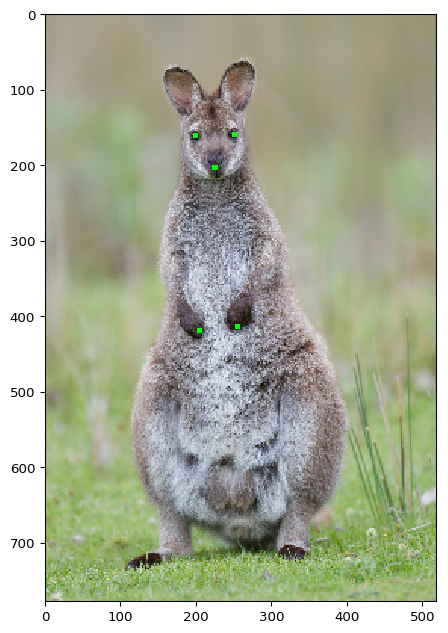

In [7]:
image_larger = ia.imresize_single_image(image, 2.0)

print("Small image %s with keypoints optimized for the size:" % (image.shape,))
ia.imshow(kpsoi.draw_on_image(image, size=7))

print("Large image %s with keypoints optimized for the small image size:" % (image_larger.shape,))
ia.imshow(kpsoi.draw_on_image(image_larger, size=7))

print("Large image %s with keypoints projected onto that size:" % (image_larger.shape,))
ia.imshow(kpsoi.on(image_larger).draw_on_image(image_larger, size=7))

## Shifting keypoints

The previously mentioned `on()` can help in cases of resized images, but not when images were padded, as in these cases the relative positions of keypoints on the image change. Such padding can be compensated for by using `KeypointsOnImage.shift(x=<number>, y=<number>)`, where `x` describes the shift to the left/right and `y` to the top/bottom.

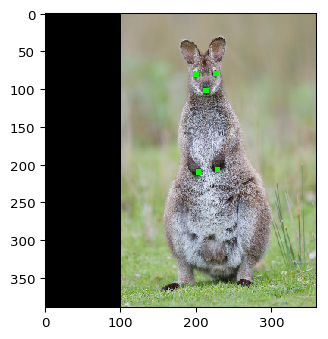

In [8]:
image_pad = ia.pad(image, left=100)
kpsoi_pad = kpsoi.shift(x=100)
ia.imshow(kpsoi_pad.draw_on_image(image_pad, size=7))

## Drawing on Images

The method `KeypointsOnImage.draw_on_image()` has been used in the previous example to visualize keypoints. It draws them on images in the form of squares. The size of these squares can be controlled using the argument `size`, as the following example shows:

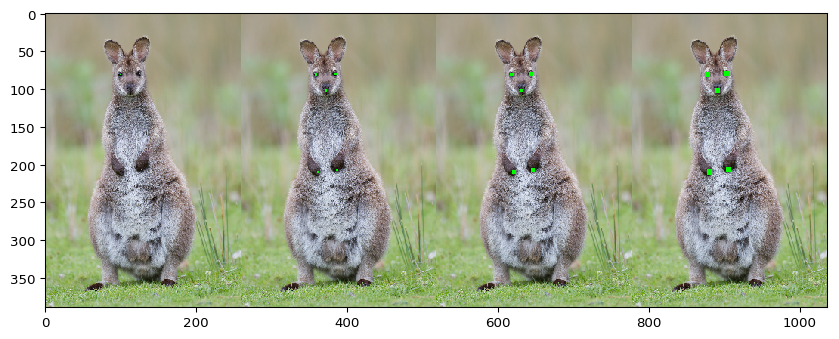

In [9]:
ia.imshow(np.hstack([
    kpsoi.draw_on_image(image, size=1),
    kpsoi.draw_on_image(image, size=3),
    kpsoi.draw_on_image(image, size=5),
    kpsoi.draw_on_image(image, size=7)
]))

The color of the drawn keypoints can be controlled using the `color` argument:

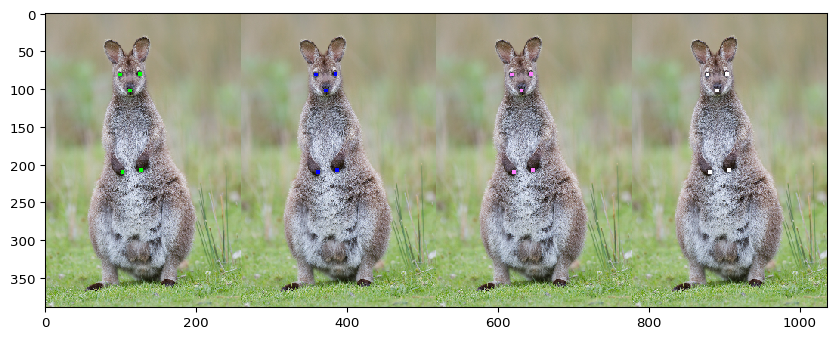

In [10]:
ia.imshow(np.hstack([
    kpsoi.draw_on_image(image, size=5, color=(0, 255, 0)),
    kpsoi.draw_on_image(image, size=5, color=(0, 0, 255)),
    kpsoi.draw_on_image(image, size=5, color=(255, 128, 255)),
    kpsoi.draw_on_image(image, size=5, color=(255, 255, 255))
]))

For improved performance, the `draw_on_image()` method also offers a `copy` flag, which can be set to `False` in order to modify an image in-place. The following example shows its usage by drawing multiple times onto the same image. Note that the example ignores whatever is returned by `draw_on_image()` and fully relies on the in-place modification, even though `draw_on_image(copy=False)` still returns the modified image. It is recommended to always use that return value, as the `copy` flag should be interpreted as a *permission* to modify in-place -- the method might still end up copying the input if that cannot be avoided.

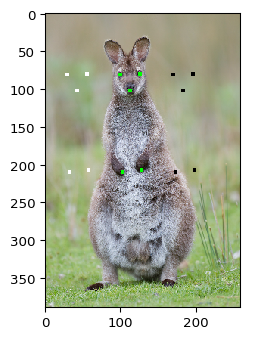

In [11]:
image_draw = np.copy(image)
kpsoi.draw_on_image(image_draw, size=5, color=(0, 255, 0), copy=False)
kpsoi.shift(x=-70).draw_on_image(image_draw, size=5, color=(255, 255, 255), copy=False)
kpsoi.shift(x=70).draw_on_image(image_draw, size=5, color=(0, 0, 0), copy=False)
ia.imshow(image_draw)

`KeypointsOnImage.draw_on_image()` does currently not have an easy way of choosing the color per keypoint. This can however be achieved by calling `Keypoint.draw_on_image()` on each individual keypoints. The following code block shows an example:

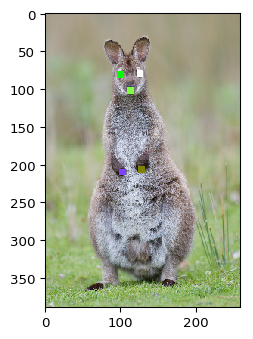

In [12]:
colors = [(0, 255, 0),
          (255, 255, 255),
          (128, 255, 64),
          (128, 64, 255),
          (128, 128, 0)]
image_drawn = np.copy(image)
for kp, color in zip(kpsoi.keypoints, colors):
    image_drawn = kp.draw_on_image(image_drawn, color=color, size=9, copy=False)
ia.imshow(image_drawn)

## Converting Keypoints to Distance Maps

When training a model for keypoint prediction, the network's output is likely not going to be the xy-coordinates of each keypoint. Instead, heatmaps are a common form to represent the keypoint locations, with values going towards `1.0` where the ground truth location of the keypoint is (or where the network thinks it is). Keypoints can be transformed into such representations in `imgaug` using `to_distance_maps()`, which converts each keypoint to a 2D distance map based on euclidean distance. In the following example, the previously used keypoints are transformed to such distance maps:

In [13]:
distance_maps = kpsoi.to_distance_maps()
print("Image shape:", kpsoi.shape)
print("Distance maps shape:", distance_maps.shape)
print("Distance maps dtype:", distance_maps.dtype)
print("Distance maps min:", distance_maps.min(), "max:", distance_maps.max())

Image shape: (389, 259, 5)
Distance maps shape: (389, 259, 5)
Distance maps dtype: float32
Distance maps min: 0.0 max: 345.7311


As the printed values show, we get distance maps of the same height and width as the image. We also actually get one distance map per keypoint. The maps are not normalized and hence can exceed the value range `[0.0, 1.0]`. Let's normalize them now based on the maximum possible euclidean distance:

In [14]:
height, width = kpsoi.shape[0:2]
max_distance = np.linalg.norm(np.float32([height, width]))
distance_maps_normalized = distance_maps / max_distance
print("min:", distance_maps.min(), "max:", distance_maps_normalized.max())

min: 0.0 max: 0.7397929


`imgaug` has support for heatmaps and in that context offers helper functions for heatmap drawing. We can leverage these here to quickly visualize the distance maps:

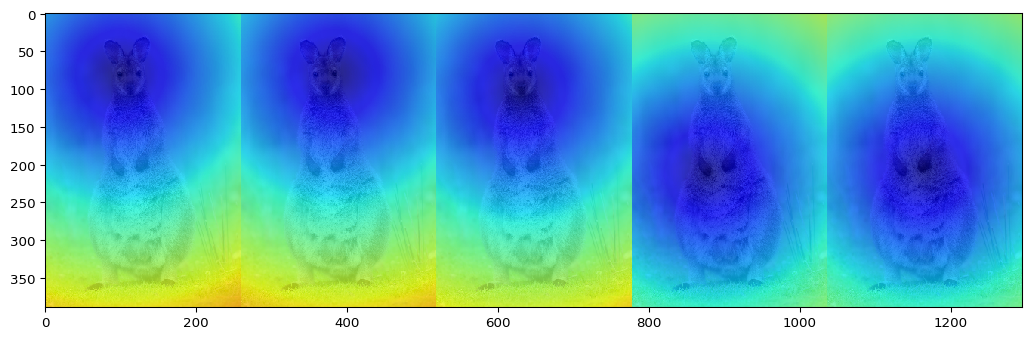

In [15]:
from imgaug.augmentables.heatmaps import HeatmapsOnImage
heatmaps = HeatmapsOnImage(distance_maps_normalized, shape=kpsoi.shape)
ia.imshow(np.hstack(heatmaps.draw_on_image(image)))

As you can see, the heatmaps value increases with the distance from each respective keypoint. Usually the inverse is used for network outputs. It is also common to have significantly more localized activations. Hence, we invert now the heatmap and apply a strong exponent to it:

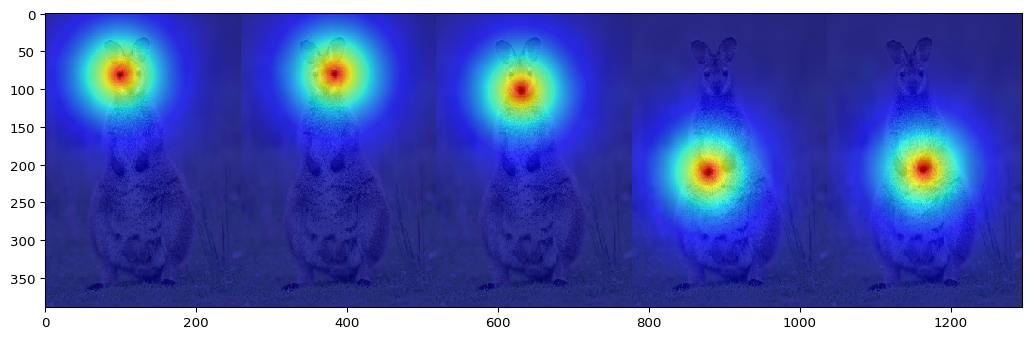

In [16]:
heatmaps = HeatmapsOnImage((1.0 - distance_maps_normalized)**10, shape=kpsoi.shape)
ia.imshow(np.hstack(heatmaps.draw_on_image(image)))

This looks like something we could train on.

Note that most publications represent keypoints as *gaussians* with hand-adjusted sigmas placed on images. Using distance maps may or may not perform similarly.

## Keypoints to/from Numpy Arrays

An instance of `KeypointsOnImage` can easily be converted to an `(N, 2)` float32 numpy array in xy-coordinate form:

In [17]:
arr = kpsoi.to_xy_array()
print("Keypoints as objects:", kpsoi.keypoints)
print("Keypoints as array:", arr)
print("Shape:", arr.shape)

Keypoints as objects: [Keypoint(x=99.00000000, y=81.00000000), Keypoint(x=125.00000000, y=80.00000000), Keypoint(x=112.00000000, y=102.00000000), Keypoint(x=102.00000000, y=210.00000000), Keypoint(x=127.00000000, y=207.00000000)]
Keypoints as array: [[ 99.  81.]
 [125.  80.]
 [112. 102.]
 [102. 210.]
 [127. 207.]]
Shape: (5, 2)


Similarly, a `KeypointsOnImage` object can be created from an `(N, 2)` array. Note though, that you have to provide the image shape via the `shape` argument:

In [18]:
xy = np.float32([
    [10, 20],
    [50, 17],
    [27.54, 49.13]
])
image_height = 50
image_width = 100
kpsoi_new = ia.KeypointsOnImage.from_xy_array(xy, shape=(image_height, image_width, 3))
print(kpsoi_new)

KeypointsOnImage([Keypoint(x=10.00000000, y=20.00000000), Keypoint(x=50.00000000, y=17.00000000), Keypoint(x=27.54000092, y=49.13000107)], shape=(50, 100, 3))
